In [ ]:
%%capture
!pip install efficientnet
!pip install pytorch-lightning
!pip install efficientnet_pytorch

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn


from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split,KFold,GridSearchCV,TimeSeriesSplit
from sklearn.preprocessing import PowerTransformer,MinMaxScaler,RobustScaler,OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer

from tqdm import tqdm

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
import tensorflow.keras.optimizers as optimizers
import tensorflow.keras.losses as losses
import tensorflow.keras.activations as activations
import tensorflow.keras.metrics as metrics

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Conv2D, AveragePooling2D, MaxPool2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import mse,mae, BinaryCrossentropy
from tensorflow.keras.activations import relu, sigmoid, softmax
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.regularizers import L1, L2, L1L2

import tensorflow_hub as tf_hub
from tensorflow.keras.applications import ResNet50
import efficientnet.tfkeras as efn



import torch
from torchvision.models import resnet50
from efficientnet_pytorch import EfficientNet
import pytorch_lightning as pl

from PIL import Image
import albumentations as A


For the ease of navigation I have separated the homework into tensorflow and pytorch part. They are pretty much identical with some framework-specific exceprions.

# Tensorflow homework

### Regression

Removing ground truth columns we are not interested in.

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Work/Epam DS Course/Regression/Copy of AirQualityUCI.csv',
                              sep=';', decimal=',', 
                              na_values=-200).iloc[:,:-2]
data = data.loc[~data['C6H6(GT)'].isnull(),[col for col in data.columns if '(GT)' not in col or col=='C6H6(GT)']]
data.loc[:,'Date'] = pd.to_datetime(data.loc[:,'Date']+' '+data.loc[:,'Time'],
                                    format='%d/%m/%Y %H.%M.%S')
data['Month'], data['Hour'], data['Day_week'] = \
data['Date'].dt.month, data['Date'].dt.hour, data['Date'].dt.dayofweek
train = data.iloc[:int(0.8*(len(data))),:]
test = data.iloc[int(0.8*len(data)):,:]
test.tail(12)

Date      Time  PT08.S1(CO)  ...  Month  Hour  Day_week
9345 2005-04-04 03:00:00  03.00.00        887.0  ...      4     3         0
9346 2005-04-04 04:00:00  04.00.00        864.0  ...      4     4         0
9347 2005-04-04 05:00:00  05.00.00        888.0  ...      4     5         0
9348 2005-04-04 06:00:00  06.00.00       1031.0  ...      4     6         0
9349 2005-04-04 07:00:00  07.00.00       1384.0  ...      4     7         0
9350 2005-04-04 08:00:00  08.00.00       1446.0  ...      4     8         0
9351 2005-04-04 09:00:00  09.00.00       1297.0  ...      4     9         0
9352 2005-04-04 10:00:00  10.00.00       1314.0  ...      4    10         0
9353 2005-04-04 11:00:00  11.00.00       1163.0  ...      4    11         0
9354 2005-04-04 12:00:00  12.00.00       1142.0  ...      4    12         0
9355 2005-04-04 13:00:00  13.00.00       1003.0  ...      4    13         0
9356 2005-04-04 14:00:00  14.00.00       1071.0  ...      4    14         0

[12 rows x 14 columns]

Preprocess data using PowerTransform and KNN imputer.

In [ ]:
transformer = ColumnTransformer([('power',
                                  sklearn.pipeline.Pipeline([('std',StandardScaler()),('pow',PowerTransformer())]),
                                  [col for col in data.columns if col not in ['Date','Time','C6H6(GT)','Month','Hour','Day_week']]),
                                 ('minmax',MinMaxScaler(),['Month','Hour','Day_week'])])
pipeline = sklearn.pipeline.Pipeline([('transf',transformer),('imputer',KNNImputer())])
dataset = pipeline.fit_transform(train)

target_pipeline = PowerTransformer()
def inv(pred):
    return target_pipeline.inverse_transform(pred)
target = target_pipeline.fit_transform(train[['C6H6(GT)']])

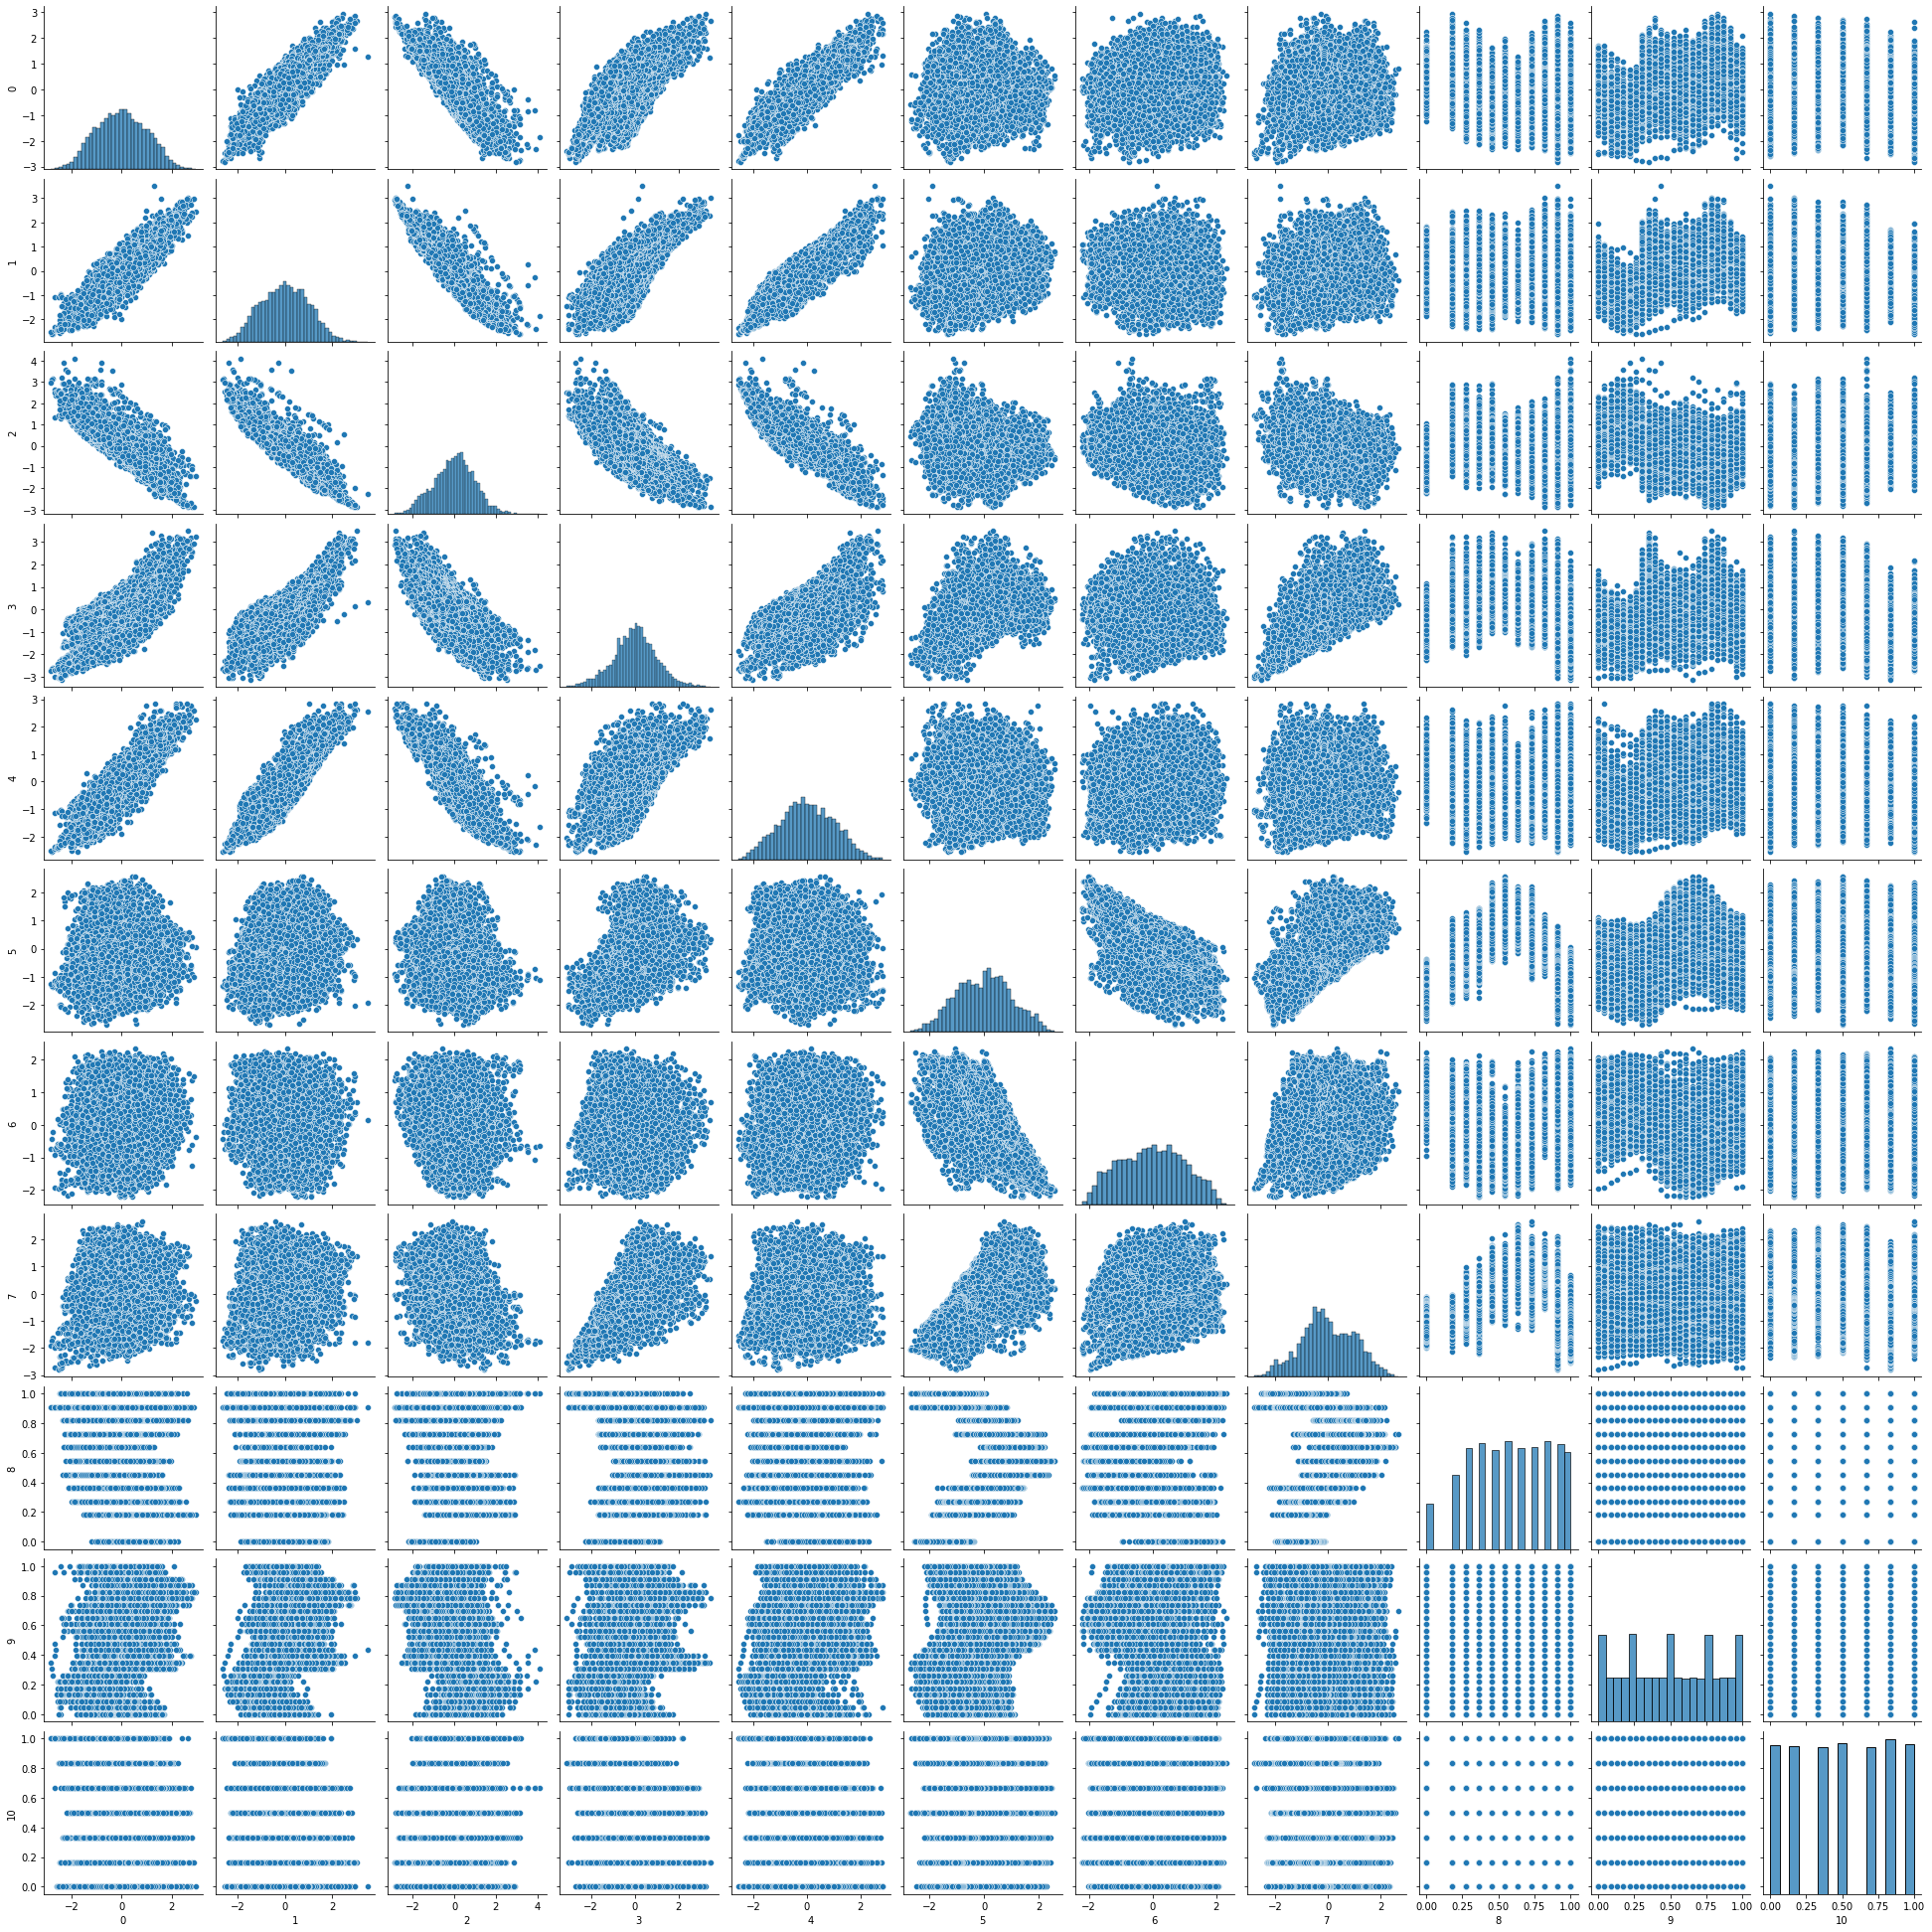

In [ ]:
sns.pairplot(pd.DataFrame(dataset))

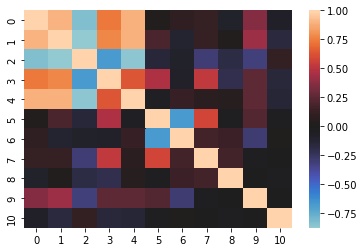

In [ ]:
sns.heatmap(pd.DataFrame(dataset).corr(),center=0)

A simple baseline model with input->4->3->1 architecture turned out to be quite decent in terms of generalizing. I use all the metrics and losses valid to a regression task.

In [ ]:
def get_model():
    i = Input((dataset.shape[-1],))
    x = Dense(4,activation='swish')(i)
    x = Dense(3,activation='swish')(x)
    out = Dense(1,activation='linear')(x)
    model = Model(i,out)
    model.compile(optimizer='adam',loss='mse',metrics=[metrics.RootMeanSquaredError(),mae])
    return model

The following two methods implement the training and testing phases of a created model.

In [ ]:
def process_model(data=(dataset,target),batch_size=256,epochs=150):
    scores = []
    X,y = data
    kfold = TimeSeriesSplit()
    for train,val in kfold.split(X):
        model = get_model()
        model.fit(X[train],y[train],epochs=epochs,batch_size=batch_size,verbose=0)
        scores.append(model.evaluate(X[val],y[val],batch_size=batch_size,verbose=0))
    scores = pd.DataFrame(scores,columns=model.metrics_names)
    model = get_model()
    model.fit(X,y,epochs=epochs,batch_size=batch_size,verbose=0)
    return scores,model

def test_model(model,data=test,batch_size=256):
    X = pipeline.transform(data)
    y = target_pipeline.transform(data[['C6H6(GT)']]).flatten()
    y_inv = np.array(data[['C6H6(GT)']]).flatten()
    pred = model.predict(X).flatten()
    pred_inv = inv(pred.reshape(-1,1)).flatten()
    scores = pd.DataFrame([[mse(y,pred).numpy(),
                            metrics.RootMeanSquaredError()(y,pred).numpy(),
                            mae(y,pred).numpy(),
                            metrics.RootMeanSquaredError()(y_inv,pred_inv).numpy(),
                            mae(y_inv,pred_inv).numpy(),
                           ]],
                          columns=list(model.metrics_names)+['rmse_inv','mae_inv'])
    print(scores)
    f,axes = plt.subplots(2,1,figsize=(12,10))
    axes[0].scatter(list(range(len(X))),y_inv-pred_inv)
    axes[0].set_title('Residual analysis')
    axes[1].plot(y_inv)
    axes[1].plot(pred_inv)
    axes[1].set_title('Prediction')
    return scores

Linear regression in the previous homework yielded the following metrics on test.

mae, rmse, mae_inv, rmse_inv:

---


 0.010 | 0.021 | 0.044 | 0.067

 As we could see there is little room for error, since there is huge correlation between a single feature and a target. Same thing would apply to the neural network.

 Perhaps it would be better to take even simpler neural network.

       loss  root_mean_squared_error  mean_absolute_error
0  0.040400                 0.200997             0.149793
1  0.033230                 0.182290             0.141437
2  0.009607                 0.098016             0.074791
3  0.018931                 0.137589             0.086063
4  0.010696                 0.103423             0.068090
       loss  root_mean_squared_error  mean_absolute_error  rmse_inv  mae_inv
0  0.000321                 0.017915             0.013167   0.09293  0.06034


loss  root_mean_squared_error  mean_absolute_error  rmse_inv  mae_inv
0  0.000321                 0.017915             0.013167   0.09293  0.06034

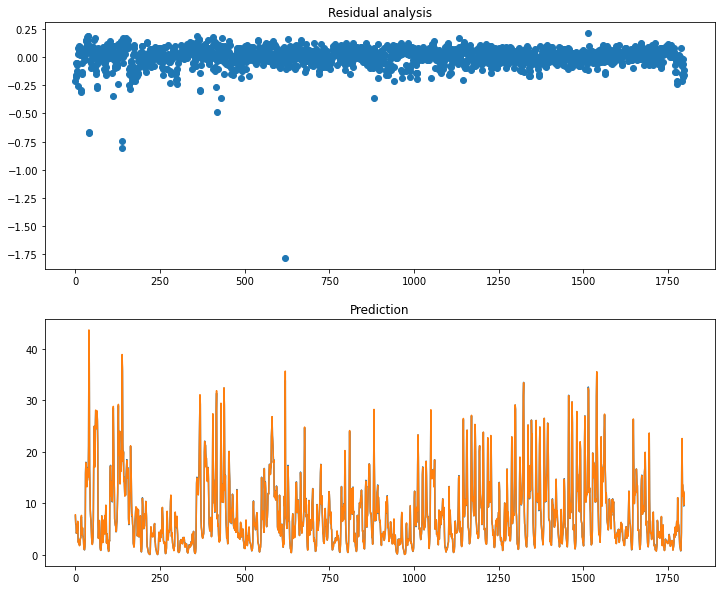

In [ ]:
s, m = process_model()
print(s)
test_model(m)

### Classification

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Work/Epam DS Course/Classification/dataset_57_hypothyroid.csv',
                   na_values='?').drop(['TBG','TBG_measured'],axis=1)
for col in data.columns:
    if set(data[col])=={'t','f'}:
        data.loc[:,col] = data[col].map({'t':1,'f':0})

data.loc[:,'sex'] = data['sex'].map({'F':1,'M':0})

# correct typo in age (455->45)
data.loc[data.age==455,'age'] = 45
print(data.head())

# remove secondary_* label
data = data.loc[data.Class!='secondary_hypothyroid',:]

data = data.iloc[np.random.permutation(range(len(data))),:]
train = data.iloc[:int(0.8*len(data)),:]
test = data.iloc[int(0.8*len(data)):,:]


    age  sex  on_thyroxine  ...    FTI  referral_source     Class
0  41.0  1.0             0  ...  109.0             SVHC  negative
1  23.0  1.0             0  ...    NaN            other  negative
2  46.0  0.0             0  ...  120.0            other  negative
3  70.0  1.0             1  ...    NaN            other  negative
4  70.0  1.0             0  ...   70.0              SVI  negative

[5 rows x 28 columns]


In [ ]:
binary_cols = [col for col in data.columns if col not in ['age','TSH','T3','TT4','T4U',
                                                          'FTI','referral_source','Class']]
column_transform = ColumnTransformer(transformers=[
    ('std',StandardScaler(),['age','TSH','T3','TT4','T4U','FTI']),
    ('one_hot',OneHotEncoder(sparse=False),['referral_source']),
    ('i',FunctionTransformer(lambda x:x,inverse_func=lambda x:x),binary_cols)
])
master_pipe = sklearn.pipeline.Pipeline(steps=[
                              ('col_pipe',column_transform),
                              ('knn',KNNImputer())
])
target_onehot = OneHotEncoder(sparse=False)
dataset = master_pipe.fit_transform(train)
test_dataset = master_pipe.transform(test)
target = target_onehot.fit_transform(train[['Class']])
test_target = target_onehot.transform(test[['Class']])

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_function_transformer.py:106: UserWarning: The provided functions are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'.
  " 'check_inverse=False'.", UserWarning)


Using the same architecture as in the regression task with the slight change in loss, output layer and metrics of course.

In [ ]:
def get_model():
    i = Input((dataset.shape[-1],))
    x = Dense(4,activation='swish')(i)
    x = Dense(3,activation='swish')(x)
    out = Dense(3,activation='softmax')(x)
    model = Model(i,out)
    model.compile(optimizer='adam',loss=losses.BinaryCrossentropy(),
                  metrics=[metrics.AUC(name='ROC'),metrics.AUC(curve='PR',name='PR')])
    return model

In [ ]:
def eval_model(data=(dataset,target),epochs=150,batch_size=256):
    scores = []
    X,y = data
    kfold = KFold()
    plt.figure(figsize=(12,7))
    plt.title('Validation ROC')
    for train,val in tqdm(kfold.split(X)):
        model = get_model()
        h = model.fit(X[train],y[train],epochs=epochs,batch_size=batch_size,validation_data=(X[val],y[val]),verbose=0)
        scores.append(model.evaluate(X[val],y[val],batch_size=batch_size,verbose=0))
        plt.plot(np.array(h.history['val_ROC']))
    scores = pd.DataFrame(scores,columns=model.metrics_names)
    model = get_model()
    h = model.fit(X,y,epochs=epochs,batch_size=batch_size,verbose=0)
    return scores,model

def test_model(model,data=(test_dataset,test_target),batch_size=256):
    res = model.evaluate(*data,batch_size=batch_size)
    print(pd.DataFrame([res],columns=model.metrics_names))

The results of fitting 5 folds are shown below.

5it [00:50, 10.13s/it]


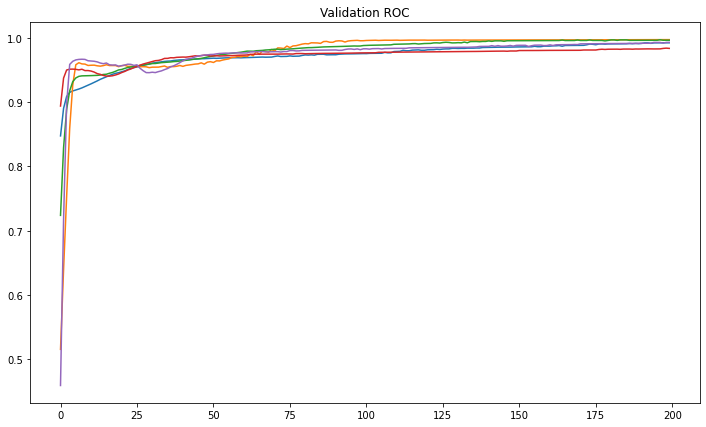

In [ ]:
s,m = eval_model(epochs=200)

In [ ]:
s

loss       ROC        PR
0  0.096336  0.992043  0.985642
1  0.137194  0.996931  0.994380
2  0.062306  0.995990  0.993228
3  0.109626  0.983331  0.967595
4  0.086146  0.992691  0.987703

Logistic regression  from previous homework yielded ROC score on TEST: 0.9651974334585197. That is more than two times worse in logarithmic scale than a neural network perpormance.

In [ ]:
test_model(m)

3/3 [==============================] - 1s 6ms/step - loss: 0.0565 - ROC: 0.9963 - PR: 0.9928
       loss       ROC        PR
0  0.056531  0.996265  0.992769


### CV

Unpack archived images

In [ ]:
import zipfile
import os
if not os.path.exists('/content/cv_data'):
    with zipfile.ZipFile('/content/drive/MyDrive/Work/Epam DS Course/CV/hotdog__not_hotdog.zip') as z:
        z.extractall('/content/cv_data/')

IMAGE_SIZE = [224,224]
BATCH = 16
AUTO = tf.data.AUTOTUNE


Helper methods for fetching data filepaths and their labels.

In [ ]:
def get_files_list(path='/content/cv_data/hotdog__not_hotdog/',extension='jpg',mode='train'):
    if mode is not None:
        path = os.path.join(path,mode)
    out = sum([[os.path.join(d,p_) for p_ in p] for d,_,p in os.walk(path)],[])
    out = [f for f in out if f.endswith(f'.{extension}')]
    return out

def get_label(path):
    if not isinstance(path,str):
        path = path.numpy().decode('utf-8')
    return int(path.split('/')[-2] == 'hot_dog')


All the images provided have at least one dimention at 512, while other may vary. So I pad them to 512^2 and then resize to IMAGE_SIZE. I took 224 because it corresponds with efficientnet-b0 input size.
As an augmentation technique I used flip,rotation, noise and random contrast.

I loop the train dataset 3 times in an epoch to cover more augmentation variants.

In [ ]:
def process_image(image,train=False):
    if not isinstance(image,np.ndarray):
        image = image.numpy()
    if not train:
        t = A.Compose([A.PadIfNeeded(512,512,border_mode=0),
                       A.Resize(*IMAGE_SIZE)])
    else:
        t = A.Compose([A.PadIfNeeded(512,512,border_mode=0),
                       A.Resize(*IMAGE_SIZE),
                       A.Flip(),
                       A.GaussNoise(),
                       A.Rotate(),
                       A.RandomContrast()])
    return t(image=image)['image']

def get_data_item(file,train=False):
    if not isinstance(file,str):
        file = file.numpy().decode('utf-8')
    label = get_label(file)
    image = process_image(np.asarray(Image.open(file)),train=train)
    return image,label

def get_train_dataset(files, valid=0.1,shuffle=True,loops=3):
    if shuffle:
        files = np.random.permutation(files)
    train_files, valid_files = files[:int((1-valid)*len(files))],files[int((1-valid)*len(files)):]
    
    t = tf.data.Dataset.from_tensor_slices(train_files)
    t = t.map(lambda x_:tf.py_function(
        func=lambda x: get_data_item(x,train=True),
        inp=[x_],
        Tout=(tf.float32,tf.int32)),
              num_parallel_calls=AUTO).batch(BATCH).repeat(loops).prefetch(AUTO)


    v = tf.data.Dataset.from_tensor_slices(valid_files)
    v = v.map(lambda x_:tf.py_function(
        func=lambda x: get_data_item(x,train=False),
        inp=[x_],
        Tout=(tf.float32,tf.int32)),
              num_parallel_calls=AUTO).batch(BATCH).prefetch(AUTO)
    return t,v

def get_test_dataset(files):
    t = tf.data.Dataset.from_tensor_slices(files)
    t = t.map(lambda x_:tf.py_function(
        func=lambda x: get_data_item(x,train=False),
        inp=[x_],
        Tout=(tf.float32,tf.int32)),
              num_parallel_calls=AUTO).batch(BATCH).prefetch(AUTO)
    return t


In [ ]:
train,valid = get_train_dataset(get_files_list(),loops=3)
test = get_test_dataset(get_files_list(mode='test'))

A hotdog visualisation

tf.Tensor([1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1], shape=(16,), dtype=int32)


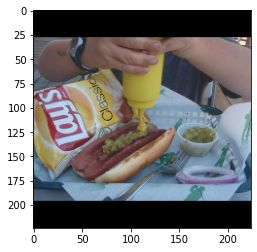

In [ ]:
t = test.take(1)
for t_ in t:
    plt.imshow(t_[0][2]/255)
    print(t_[1])

A method to get a cv model. It may produce a model with either resnet50, efficientnet-b0, or a custom backbone. Regarding custom backbone, I stack convolutional layers according to a common sense. I did not want to make it too big depth and feature wise so that it did not overfit quickly.

In [ ]:
def get_custom_backbone():
    def conv_block(head,filters,kernel=(3,3),strides=(1,1), padding='same',activation='swish'):
        x = Conv2D(filters,kernel_size=kernel,strides=strides,padding=padding)(head)
        x = layers.BatchNormalization()(x)
        x = layers.Activation(activation=activation)(x)
        return x
    
    i = Input(IMAGE_SIZE+[3])
    x = conv_block(i,32,strides=(2,2))
    x = conv_block(x,64,strides=(1,1))
    x = conv_block(x,128,kernel=(5,5),strides=(2,2))
    x = conv_block(x,256,strides=(2,2))
    x = conv_block(x,256,strides=(2,2))
    
    return Model(inputs=i,outputs=x)

def get_backbone(name=None,freeze=False):
    if name=='efficientnet':
        backbone = efn.EfficientNetB0(include_top=False,weights='imagenet')
    elif name=='resnet':
        backbone = ResNet50(include_top=False,weights='imagenet')
    else:
        backbone = get_custom_backbone()
    for l in backbone.layers:
        l.trainable = not freeze
    return backbone

def get_model(backbone=None,freeze=False, lr=0.0005):
    backbone = get_backbone(backbone,freeze)
    i = Input(IMAGE_SIZE+[3])
    x = backbone(i)
    x = AveragePooling2D(pool_size=(3,3),strides=(2,2),padding='valid')(x)
    x = layers.Flatten()(x)
    x = Dense(128)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation='swish')(x)
    x = Dense(1,activation='sigmoid')(x)

    model = Model(inputs=i,outputs=x)
    model.compile(optimizer=Adam(optimizers.schedules.CosineDecay(lr,84)),
                  loss=losses.BinaryCrossentropy(),
                  metrics=[metrics.BinaryAccuracy(),metrics.AUC(name='auc')])
    
    return model


During the training phase I use earlystopping to prevent overfitting.

In [ ]:
def train_model(model):
    history = model.fit(train,validation_data=valid,epochs=20,
      callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy',patience=3)])
    f,axes = plt.subplots(1,2,figsize=(10,7))
    axes[0].plot(history.history['loss'],label='loss')
    axes[0].plot(history.history['val_loss'],label='val_loss')
    axes[0].legend()
    axes[1].plot(history.history['binary_accuracy'],label='accuracy')
    axes[1].plot(history.history['val_binary_accuracy'],label='val_accuracy')
    axes[1].legend()

    plt.title('Learning curves')
    plt.show()
    print('TEST RESULTS: - - - - -')
    print(model.evaluate(test))
    

As expected, the quality of cv model trained from scratch with little data is bad.

Epoch 1/20
84/84 [==============================] - 54s 257ms/step - loss: 0.6373 - binary_accuracy: 0.6496 - auc: 0.7128 - val_loss: 1.0298 - val_binary_accuracy: 0.6406 - val_auc: 0.7604
Epoch 2/20
84/84 [==============================] - 21s 250ms/step - loss: 0.5377 - binary_accuracy: 0.7225 - auc: 0.7997 - val_loss: 0.5454 - val_binary_accuracy: 0.7656 - val_auc: 0.7973
Epoch 3/20
84/84 [==============================] - 21s 250ms/step - loss: 0.5378 - binary_accuracy: 0.7143 - auc: 0.7994 - val_loss: 0.5210 - val_binary_accuracy: 0.7969 - val_auc: 0.8213
Epoch 4/20
84/84 [==============================] - 21s 248ms/step - loss: 0.5474 - binary_accuracy: 0.7039 - auc: 0.7878 - val_loss: 0.5223 - val_binary_accuracy: 0.7969 - val_auc: 0.8173
Epoch 5/20
84/84 [==============================] - 21s 247ms/step - loss: 0.5405 - binary_accuracy: 0.7121 - auc: 0.7925 - val_loss: 0.5231 - val_binary_accuracy: 0.8125 - val_auc: 0.8197
Epoch 6/20
84/84 [==============================] - 21s

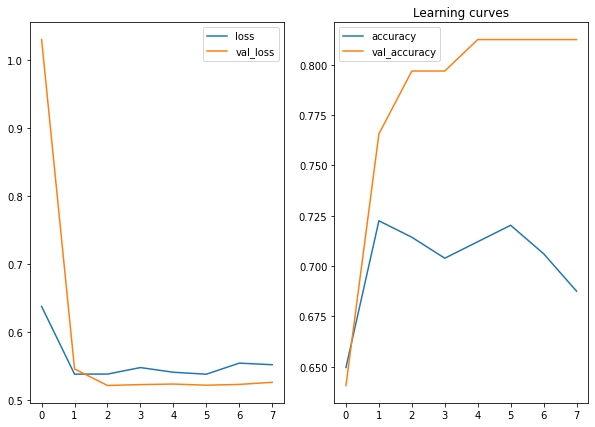

TEST RESULTS: - - - - -
32/32 [==============================] - 4s 128ms/step - loss: 0.6333 - binary_accuracy: 0.6406 - auc: 0.6800
[0.6333014369010925, 0.640625, 0.6800239682197571]


In [ ]:
m = get_model(freeze=False, lr=0.001)
train_model(m)

A frozen pretrained efficient net seems not enough for this task.

16818176/16804768 [==============================] - 0s 0us/step
Epoch 1/20
84/84 [==============================] - 28s 229ms/step - loss: 0.7382 - binary_accuracy: 0.5417 - auc: 0.5517 - val_loss: 0.6920 - val_binary_accuracy: 0.7344 - val_auc: 0.5954
Epoch 2/20
84/84 [==============================] - 17s 203ms/step - loss: 0.6902 - binary_accuracy: 0.5766 - auc: 0.5823 - val_loss: 0.6903 - val_binary_accuracy: 0.5156 - val_auc: 0.6130
Epoch 3/20
84/84 [==============================] - 17s 199ms/step - loss: 0.7109 - binary_accuracy: 0.5499 - auc: 0.5650 - val_loss: 0.6907 - val_binary_accuracy: 0.5156 - val_auc: 0.6242
Epoch 4/20
84/84 [==============================] - 18s 210ms/step - loss: 0.7162 - binary_accuracy: 0.5387 - auc: 0.5519 - val_loss: 0.6890 - val_binary_accuracy: 0.5156 - val_auc: 0.6274


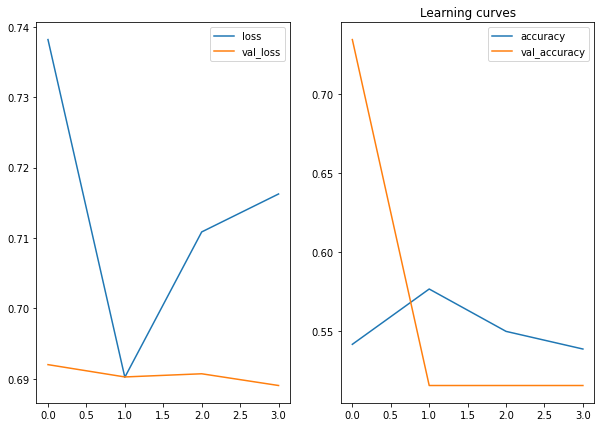

TEST RESULTS: - - - - -
32/32 [==============================] - 6s 182ms/step - loss: 0.6913 - binary_accuracy: 0.5215 - auc: 0.5610
[0.6912883520126343, 0.521484375, 0.5609999299049377]


In [ ]:
m_eff_frozen = get_model('efficientnet',freeze=True)
train_model(m_eff_frozen)

An unfrozen one performs way way better.

Epoch 1/20
84/84 [==============================] - 48s 427ms/step - loss: 0.4157 - binary_accuracy: 0.8423 - auc: 0.9124 - val_loss: 0.4765 - val_binary_accuracy: 0.8750 - val_auc: 0.9295
Epoch 2/20
84/84 [==============================] - 35s 410ms/step - loss: 0.2075 - binary_accuracy: 0.9115 - auc: 0.9739 - val_loss: 0.2837 - val_binary_accuracy: 0.8906 - val_auc: 0.9503
Epoch 3/20
84/84 [==============================] - 34s 407ms/step - loss: 0.1941 - binary_accuracy: 0.9256 - auc: 0.9774 - val_loss: 0.2863 - val_binary_accuracy: 0.8906 - val_auc: 0.9527
Epoch 4/20
84/84 [==============================] - 35s 412ms/step - loss: 0.2024 - binary_accuracy: 0.9204 - auc: 0.9744 - val_loss: 0.2808 - val_binary_accuracy: 0.8906 - val_auc: 0.9527
Epoch 5/20
84/84 [==============================] - 34s 405ms/step - loss: 0.2156 - binary_accuracy: 0.9055 - auc: 0.9716 - val_loss: 0.2790 - val_binary_accuracy: 0.8906 - val_auc: 0.9535


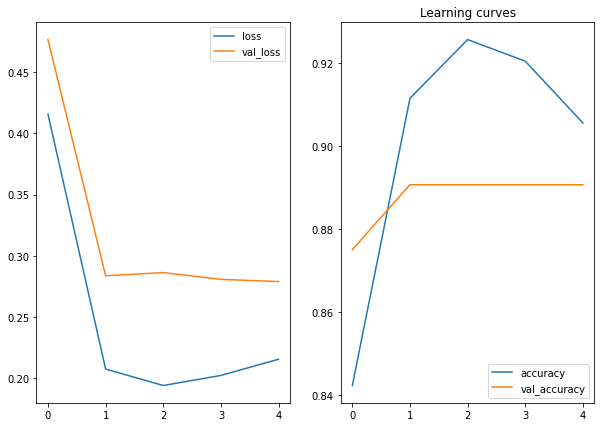

TEST RESULTS: - - - - -
32/32 [==============================] - 5s 148ms/step - loss: 0.3324 - binary_accuracy: 0.8789 - auc: 0.9496
[0.33243799209594727, 0.87890625, 0.949592113494873]


In [ ]:
m_eff = get_model('efficientnet',freeze=False)
train_model(m_eff)

Resnet has twice as bigger feature size than efnb0. I bet that is the reason it could achieve this high metrics in frozen state.

94781440/94765736 [==============================] - 1s 0us/step
Epoch 1/20
84/84 [==============================] - 30s 286ms/step - loss: 0.3924 - binary_accuracy: 0.8348 - auc: 0.9227 - val_loss: 0.4032 - val_binary_accuracy: 0.8906 - val_auc: 0.9527
Epoch 2/20
84/84 [==============================] - 22s 258ms/step - loss: 0.2974 - binary_accuracy: 0.8757 - auc: 0.9485 - val_loss: 0.3431 - val_binary_accuracy: 0.8750 - val_auc: 0.9535
Epoch 3/20
84/84 [==============================] - 22s 260ms/step - loss: 0.2777 - binary_accuracy: 0.8891 - auc: 0.9536 - val_loss: 0.3372 - val_binary_accuracy: 0.8906 - val_auc: 0.9535
Epoch 4/20
84/84 [==============================] - 22s 259ms/step - loss: 0.2837 - binary_accuracy: 0.8869 - auc: 0.9534 - val_loss: 0.3323 - val_binary_accuracy: 0.8906 - val_auc: 0.9535


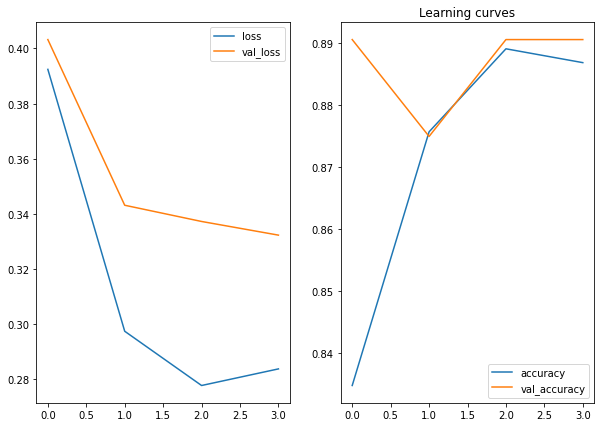

TEST RESULTS: - - - - -
32/32 [==============================] - 7s 220ms/step - loss: 0.3757 - binary_accuracy: 0.8555 - auc: 0.9377
[0.3757099211215973, 0.85546875, 0.9377040266990662]


In [ ]:
m_res_frozen = get_model('resnet',freeze=True)
train_model(m_res_frozen)

Epoch 1/20
84/84 [==============================] - 53s 526ms/step - loss: 0.6096 - binary_accuracy: 0.7552 - auc: 0.8315 - val_loss: 5.0531 - val_binary_accuracy: 0.5469 - val_auc: 0.5801
Epoch 2/20
84/84 [==============================] - 43s 511ms/step - loss: 0.3813 - binary_accuracy: 0.8311 - auc: 0.9192 - val_loss: 1.3580 - val_binary_accuracy: 0.7500 - val_auc: 0.7524
Epoch 3/20
84/84 [==============================] - 43s 509ms/step - loss: 0.3772 - binary_accuracy: 0.8341 - auc: 0.9194 - val_loss: 0.8424 - val_binary_accuracy: 0.8125 - val_auc: 0.8165
Epoch 4/20
84/84 [==============================] - 43s 508ms/step - loss: 0.3610 - binary_accuracy: 0.8519 - auc: 0.9319 - val_loss: 0.6445 - val_binary_accuracy: 0.8125 - val_auc: 0.8325
Epoch 5/20
84/84 [==============================] - 43s 508ms/step - loss: 0.3440 - binary_accuracy: 0.8504 - auc: 0.9358 - val_loss: 0.5667 - val_binary_accuracy: 0.8125 - val_auc: 0.8397
Epoch 6/20
84/84 [==============================] - 43s

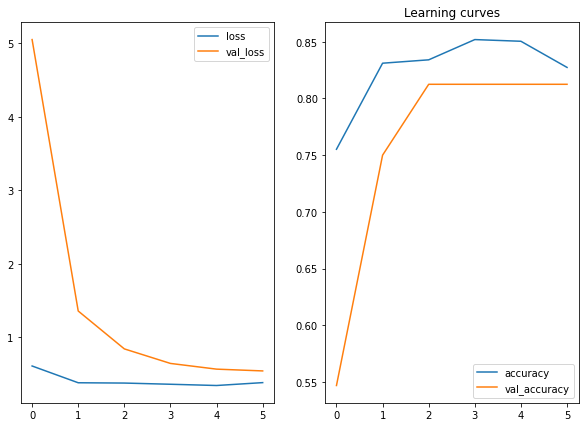

TEST RESULTS: - - - - -
32/32 [==============================] - 7s 203ms/step - loss: 0.4928 - binary_accuracy: 0.8105 - auc: 0.9047
[0.4927516281604767, 0.810546875, 0.904711902141571]


In [ ]:
m_res = get_model('resnet',freeze=False)
train_model(m_res)

# Pytorch

Since the general ideas in this section are identical to the tensorflow section, I am only going to comment on framework specific aspects.

### Regression

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Work/Epam DS Course/Regression/Copy of AirQualityUCI.csv',
                              sep=';', decimal=',', 
                              na_values=-200).iloc[:,:-2]
data = data.loc[~data['C6H6(GT)'].isnull(),[col for col in data.columns if '(GT)' not in col or col=='C6H6(GT)']]
data.loc[:,'Date'] = pd.to_datetime(data.loc[:,'Date']+' '+data.loc[:,'Time'],
                                    format='%d/%m/%Y %H.%M.%S')
data['Month'], data['Hour'], data['Day_week'] = \
data['Date'].dt.month, data['Date'].dt.hour, data['Date'].dt.dayofweek
train = data.iloc[:int(0.8*(len(data))),:]
test = data.iloc[int(0.8*len(data)):,:]
test.tail(12)

Date      Time  PT08.S1(CO)  ...  Month  Hour  Day_week
9345 2005-04-04 03:00:00  03.00.00        887.0  ...      4     3         0
9346 2005-04-04 04:00:00  04.00.00        864.0  ...      4     4         0
9347 2005-04-04 05:00:00  05.00.00        888.0  ...      4     5         0
9348 2005-04-04 06:00:00  06.00.00       1031.0  ...      4     6         0
9349 2005-04-04 07:00:00  07.00.00       1384.0  ...      4     7         0
9350 2005-04-04 08:00:00  08.00.00       1446.0  ...      4     8         0
9351 2005-04-04 09:00:00  09.00.00       1297.0  ...      4     9         0
9352 2005-04-04 10:00:00  10.00.00       1314.0  ...      4    10         0
9353 2005-04-04 11:00:00  11.00.00       1163.0  ...      4    11         0
9354 2005-04-04 12:00:00  12.00.00       1142.0  ...      4    12         0
9355 2005-04-04 13:00:00  13.00.00       1003.0  ...      4    13         0
9356 2005-04-04 14:00:00  14.00.00       1071.0  ...      4    14         0

[12 rows x 14 columns]

Preprocess data using PowerTransform and KNN imputer.

In [ ]:
transformer = ColumnTransformer([('power',
                                  sklearn.pipeline.Pipeline([('std',StandardScaler()),('pow',PowerTransformer())]),
                                  [col for col in data.columns if col not in ['Date','Time','C6H6(GT)','Month','Hour','Day_week']]),
                                 ('minmax',MinMaxScaler(),['Month','Hour','Day_week'])])
pipeline = sklearn.pipeline.Pipeline([('transf',transformer),('imputer',KNNImputer())])
dataset = pipeline.fit_transform(train)

target_pipeline = PowerTransformer()
def inv(pred):
    return target_pipeline.inverse_transform(pred)
target = target_pipeline.fit_transform(train[['C6H6(GT)']])

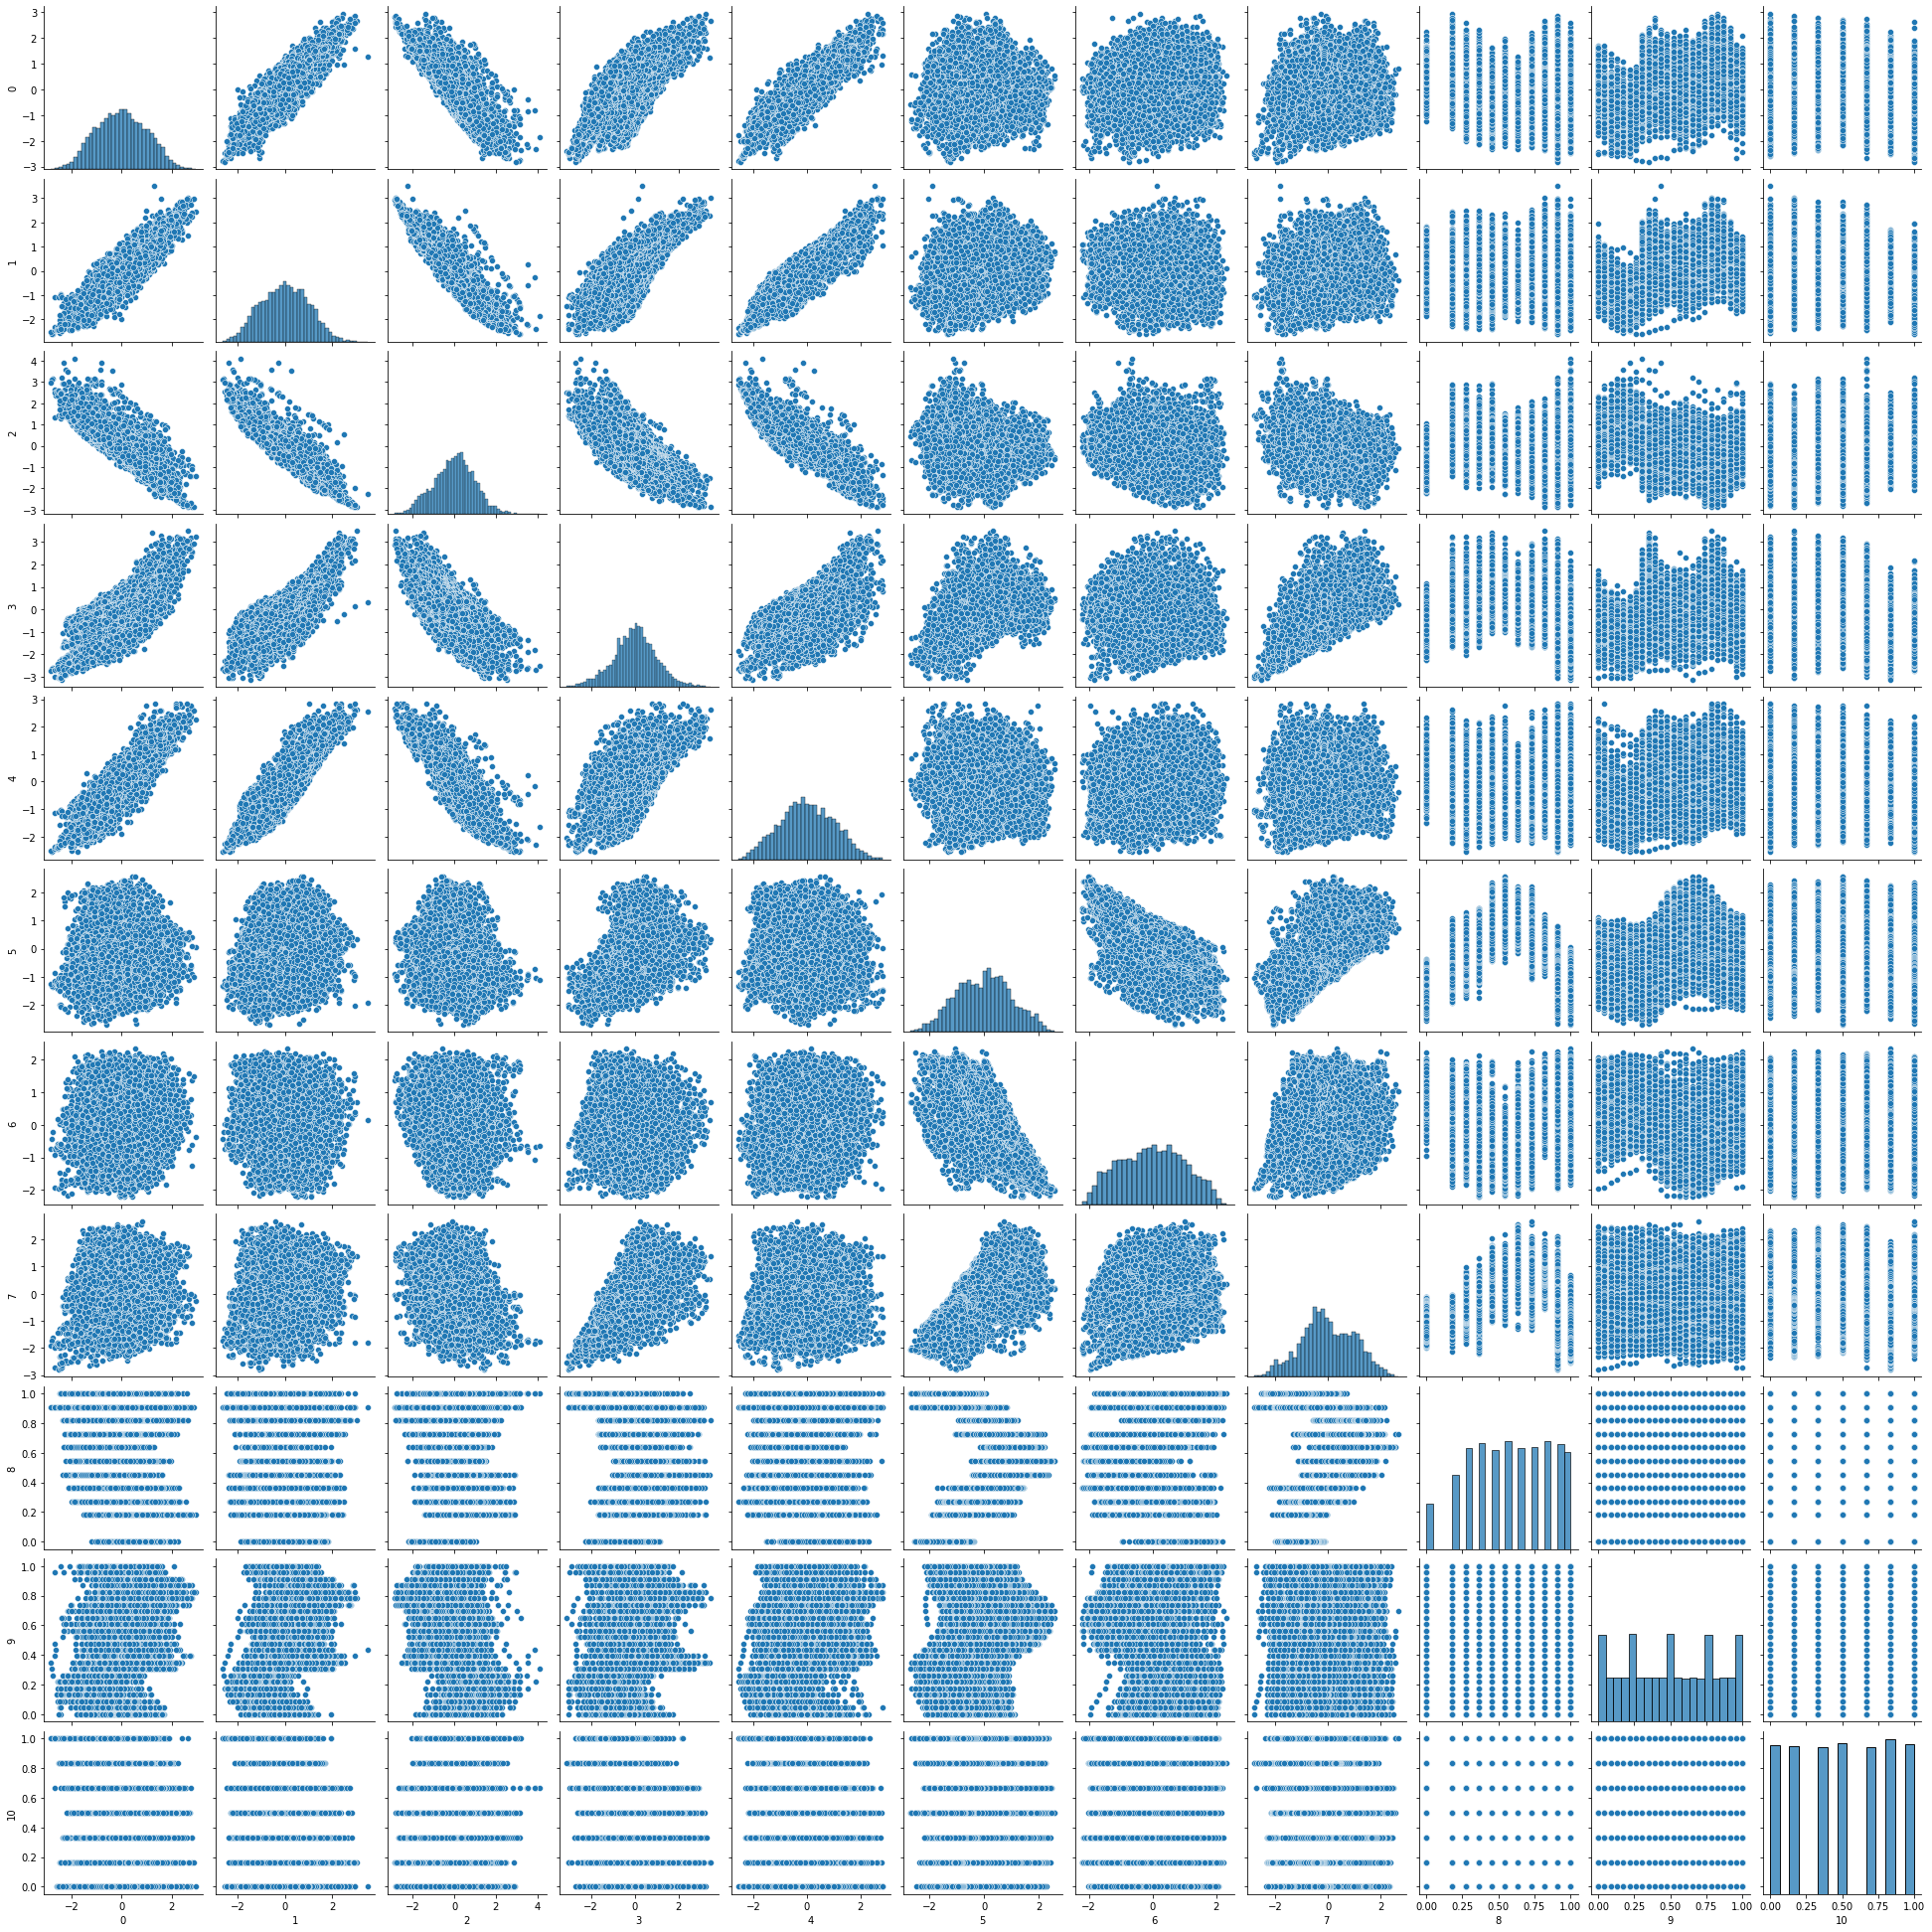

In [ ]:
sns.pairplot(pd.DataFrame(dataset))

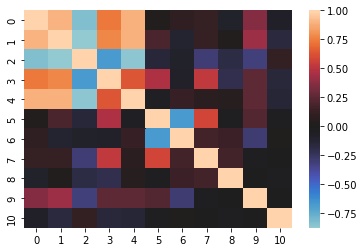

In [ ]:
sns.heatmap(pd.DataFrame(dataset).corr(),center=0)

Pytorch does provides a better version of swish function - mish.

In [ ]:
class RegModel(torch.nn.Module):
    def __init__(self):
        super(RegModel,self).__init__()
        self.layer1 = torch.nn.Sequential(
            torch.nn.Linear(dataset.shape[-1],4),
            torch.nn.Mish(),
        )
        self.layer2 = torch.nn.Sequential(
            torch.nn.Linear(4,3),
            torch.nn.Mish(),
        )
        self.out = torch.nn.Sequential(
            torch.nn.Linear(3,1),
        )
    
    def forward(self,x):
        x_ = self.layer1(x)
        x_ = self.layer2(x_)
        out = self.out(x_)
        return out

def get_model():
    model = RegModel()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss = torch.nn.MSELoss()
    model_metrics = [metrics.RootMeanSquaredError(),metrics.MeanAbsoluteError()]
    return model, {'model':model,
                   'optimizer':optimizer,
                   'loss':loss,
                   'metrics':model_metrics}

There are no in-built utility functions for training and evaluating, so I wrote the loops as follows.

In [ ]:
def fit(m_dict,X,y,epochs=150):
    model, optimizer, loss_fn, model_metrics =\
     m_dict['model'], m_dict['optimizer'], m_dict['loss'], m_dict['metrics']
    
    model.train()
    for epoch in tqdm(range(epochs)):
        for x,label in zip(X,y):
            optimizer.zero_grad()
            pred = model(x)
            loss = loss_fn(pred,label)
            loss.backward()
            optimizer.step()

def evaluate(m_dict,X,y):
    model, optimizer, loss_fn, model_metrics \
    = m_dict['model'], m_dict['optimizer'], m_dict['loss'], m_dict['metrics']
    scores = {}
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x,label in zip(X,y):
            pred = model(x).detach().numpy()
            preds.extend(pred)
            labels.extend(label.numpy())

    for metric in model_metrics:
        scores[metric.name] = metric(preds,labels) 
    
    print('Eval results')
    for i,k in scores.items():
        print(f'{i}: {k}')

def process_model(data=(dataset,target),batch_size=256,epochs=250):
    X,y = data
    kfold = TimeSeriesSplit()
    for train,val in kfold.split(X):
        model, model_dict = get_model()
        X_train = torch.utils.data.DataLoader(np.array(X[train]).astype(np.float32),batch_size=batch_size)
        y_train = torch.utils.data.DataLoader(np.array(y[train]).astype(np.float32),batch_size=batch_size)
        X_val = torch.utils.data.DataLoader(np.array(X[val]).astype(np.float32),batch_size=batch_size)
        y_val = torch.utils.data.DataLoader(np.array(y[val]).astype(np.float32),batch_size=batch_size)
        fit(model_dict,X_train,y_train,epochs=epochs)
        evaluate(model_dict,X_val,y_val)
    model,model_dict = get_model()
    X = torch.utils.data.DataLoader(np.array(X).astype(np.float32),batch_size=batch_size)
    y = torch.utils.data.DataLoader(np.array(y).astype(np.float32),batch_size=batch_size)
    fit(model_dict,X,y,epochs=epochs)
    
    return model

def test_model(model,data=test,batch_size=256):
    model.eval()
    X = pipeline.transform(data)
    y = target_pipeline.transform(data[['C6H6(GT)']]).flatten()
    y_inv = np.array(data[['C6H6(GT)']]).flatten()
    preds = []
    with torch.no_grad():
        for x in torch.utils.data.DataLoader(X.astype(np.float32),batch_size=256):
            preds.extend(model(x).detach().numpy())
    pred = np.array(preds).flatten()
    pred_inv = inv(pred.reshape(-1,1)).flatten()
    scores = pd.DataFrame([[mse(y,pred).numpy(),
                            metrics.RootMeanSquaredError()(y,pred).numpy(),
                            mae(y,pred).numpy(),
                            metrics.RootMeanSquaredError()(y_inv,pred_inv).numpy(),
                            mae(y_inv,pred_inv).numpy(),
                           ]],
                          columns=['loss','rmse','mae','rmse_inv','mae_inv'])
    print(scores)
    f,axes = plt.subplots(2,1,figsize=(12,10))
    axes[0].scatter(list(range(len(X))),y_inv-pred_inv)
    axes[0].set_title('Residual analysis')
    axes[1].plot(y_inv)
    axes[1].plot(pred_inv)
    axes[1].set_title('Prediction')
    return scores

The following results almost match the ones in the previous section.

100%|██████████| 250/250 [00:03<00:00, 75.60it/s]


Eval results
root_mean_squared_error: 0.18702690303325653
mean_absolute_error: 0.15272623300552368


100%|██████████| 250/250 [00:06<00:00, 38.40it/s]


Eval results
root_mean_squared_error: 0.05578231438994408
mean_absolute_error: 0.04447316378355026


100%|██████████| 250/250 [00:09<00:00, 26.02it/s]


Eval results
root_mean_squared_error: 0.14328666031360626
mean_absolute_error: 0.11590693145990372


100%|██████████| 250/250 [00:12<00:00, 20.23it/s]


Eval results
root_mean_squared_error: 0.08121960610151291
mean_absolute_error: 0.05293364077806473


100%|██████████| 250/250 [00:15<00:00, 15.90it/s]


Eval results
root_mean_squared_error: 0.07218548655509949
mean_absolute_error: 0.04401419311761856


100%|██████████| 250/250 [00:19<00:00, 13.09it/s]


TEST RESULTS:
       loss     rmse       mae  rmse_inv   mae_inv
0  0.000201  0.01419  0.010783  0.117886  0.061349


loss     rmse       mae  rmse_inv   mae_inv
0  0.000201  0.01419  0.010783  0.117886  0.061349

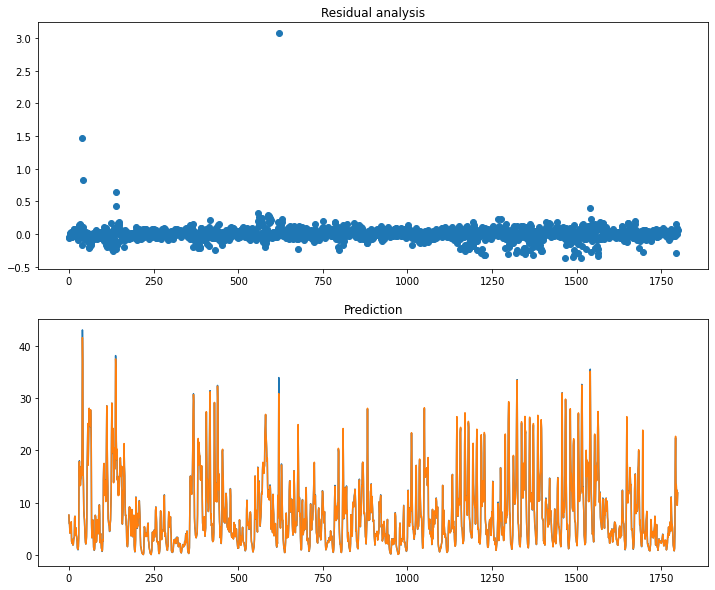

In [ ]:
m = process_model()
print('TEST RESULTS:')
test_model(m)

### Classification

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Work/Epam DS Course/Classification/dataset_57_hypothyroid.csv',
                   na_values='?').drop(['TBG','TBG_measured'],axis=1)
for col in data.columns:
    if set(data[col])=={'t','f'}:
        data.loc[:,col] = data[col].map({'t':1,'f':0})

data.loc[:,'sex'] = data['sex'].map({'F':1,'M':0})

# correct typo in age (455->45)
data.loc[data.age==455,'age'] = 45
print(data.head())

# remove secondary_* label
data = data.loc[data.Class!='secondary_hypothyroid',:]

data = data.iloc[np.random.permutation(range(len(data))),:]
train = data.iloc[:int(0.8*len(data)),:]
test = data.iloc[int(0.8*len(data)):,:]


    age  sex  on_thyroxine  ...    FTI  referral_source     Class
0  41.0  1.0             0  ...  109.0             SVHC  negative
1  23.0  1.0             0  ...    NaN            other  negative
2  46.0  0.0             0  ...  120.0            other  negative
3  70.0  1.0             1  ...    NaN            other  negative
4  70.0  1.0             0  ...   70.0              SVI  negative

[5 rows x 28 columns]


In [ ]:
binary_cols = [col for col in data.columns if col not in ['age','TSH','T3','TT4','T4U',
                                                          'FTI','referral_source','Class']]
column_transform = ColumnTransformer(transformers=[
    ('std',StandardScaler(),['age','TSH','T3','TT4','T4U','FTI']),
    ('one_hot',OneHotEncoder(sparse=False),['referral_source']),
    ('i',FunctionTransformer(lambda x:x,inverse_func=lambda x:x),binary_cols)
])
master_pipe = sklearn.pipeline.Pipeline(steps=[
                              ('col_pipe',column_transform),
                              ('knn',KNNImputer())
])
target_onehot = OneHotEncoder(sparse=False)
dataset = master_pipe.fit_transform(train)
test_dataset = master_pipe.transform(test)
target = target_onehot.fit_transform(train[['Class']])
test_target = target_onehot.transform(test[['Class']])

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_function_transformer.py:106: UserWarning: The provided functions are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'.
  " 'check_inverse=False'.", UserWarning)


In [ ]:
class ClassModel(torch.nn.Module):
    def __init__(self):
        super(ClassModel,self).__init__()
        self.layer1 = torch.nn.Sequential(
            torch.nn.Linear(dataset.shape[-1],4),
            torch.nn.Mish(),
        )
        self.layer2 = torch.nn.Sequential(
            torch.nn.Linear(4,3),
            torch.nn.Mish(),
        )
        self.out = torch.nn.Sequential(
            torch.nn.Linear(3,3),
            torch.nn.Softmax(dim=-1),
        )
    
    def forward(self,x):
        x_ = self.layer1(x)
        x_ = self.layer2(x_)
        out = self.out(x_)
        return out

def get_model():
    model = ClassModel()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss = torch.nn.BCELoss()
    model_metrics = [metrics.AUC(name='ROC'),metrics.AUC(curve='PR',name='PR')]
    return model, {'model':model,
                   'optimizer':optimizer,
                   'loss':loss,
                   'metrics':model_metrics}


In [ ]:
def fit(m_dict,X,y,valid_data=None,epochs=150):
    model, optimizer, loss_fn, model_metrics =\
     m_dict['model'], m_dict['optimizer'], m_dict['loss'], m_dict['metrics']
    
    history = {}
    for epoch in range(epochs):
        model.train()
        for x,label in zip(X,y):
            optimizer.zero_grad()
            pred = model(x)
            loss = loss_fn(pred,label)
            loss.backward()
            optimizer.step()
        if valid_data is not None:
            X_,y_ = valid_data
            scores = evaluate(m_dict,X_,y_,verbose=False)
            for i,k in scores.items():
                history[i] = history.get(i,[]) + [k]
    return history


def evaluate(m_dict,X,y,verbose=True):
    model, optimizer, loss_fn, model_metrics \
    = m_dict['model'], m_dict['optimizer'], m_dict['loss'], m_dict['metrics']
    scores = {}
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x,label in zip(X,y):
            pred = model(x).detach().numpy()
            preds.extend(pred)
            labels.extend(label.numpy())

    for metric in model_metrics:
        scores[metric.name] = metric(labels,preds) 
    
    if verbose:
        print('Eval results')
        for i,k in scores.items():
            print(f'{i}: {k}')
    return scores

def process_model(data=(dataset,target),batch_size=256,epochs=250):
    X,y = data
    kfold = KFold()
    plt.figure(figsize=(12,7))
    plt.title('Validation ROC')
    for train,val in tqdm(kfold.split(X)):
        model, model_dict = get_model()
        X_train = torch.utils.data.DataLoader(np.array(X[train]).astype(np.float32),batch_size=batch_size)
        y_train = torch.utils.data.DataLoader(np.array(y[train]).astype(np.float32),batch_size=batch_size)
        X_val = torch.utils.data.DataLoader(np.array(X[val]).astype(np.float32),batch_size=batch_size)
        y_val = torch.utils.data.DataLoader(np.array(y[val]).astype(np.float32),batch_size=batch_size)
        history = fit(model_dict,X_train,y_train,valid_data=(X_val,y_val),epochs=epochs)
        plt.plot(np.array(history['ROC']))
    model,model_dict = get_model()
    X = torch.utils.data.DataLoader(np.array(X).astype(np.float32),batch_size=batch_size)
    y = torch.utils.data.DataLoader(np.array(y).astype(np.float32),batch_size=batch_size)
    fit(model_dict,X,y,epochs=epochs)
    
    return model_dict

def test_model(m_dict,data=(test_dataset,test_target),batch_size=256):
    X,y = data
    X = torch.utils.data.DataLoader(np.array(X).astype(np.float32),batch_size=batch_size)
    y = torch.utils.data.DataLoader(np.array(y).astype(np.float32),batch_size=batch_size)
    print('TEST results:')
    scores = evaluate(m_dict,X,y)
    return scores


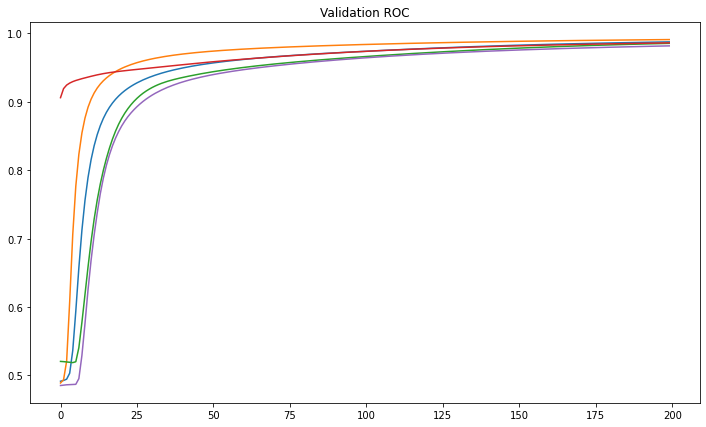

In [ ]:
m = process_model(epochs=200)

Tensorflow approach gives roughly the same result.

In [ ]:
test_model(m);

TEST results:
Eval results
ROC: 0.9975171089172363
PR: 0.9953145384788513


### CV

In [ ]:
import zipfile
import os
if not os.path.exists('/content/cv_data'):
    with zipfile.ZipFile('/content/drive/MyDrive/Work/Epam DS Course/CV/hotdog__not_hotdog.zip') as z:
        z.extractall('/content/cv_data/')

IMAGE_SIZE = [224,224]
BATCH = 16
AUTO = tf.data.AUTOTUNE


In [ ]:
def get_files_list(path='/content/cv_data/hotdog__not_hotdog/',extension='jpg',mode='train'):
    if mode is not None:
        path = os.path.join(path,mode)
    out = sum([[os.path.join(d,p_) for p_ in p] for d,_,p in os.walk(path)],[])
    out = [f for f in out if f.endswith(f'.{extension}')]
    return out

def get_label(path):
    if not isinstance(path,str):
        path = path.numpy().decode('utf-8')
    return np.array(path.split('/')[-2] == 'hot_dog',dtype=np.float32)


Pytorch requires the channels-first data format:

In [ ]:
def process_image(image,train=False):
    if not isinstance(image,np.ndarray):
        image = image.numpy()
    if not train:
        t = A.Compose([A.PadIfNeeded(512,512,border_mode=0),
                       A.Resize(*IMAGE_SIZE)])
    else:
        t = A.Compose([A.PadIfNeeded(512,512,border_mode=0),
                       A.Resize(*IMAGE_SIZE),
                       A.Flip(),
                       A.GaussNoise(),
                       A.Rotate(),
                       A.RandomContrast()])
    return t(image=image)['image'].astype(np.float32)/255.0

def get_data_item(file,train=False):
    if not isinstance(file,str):
        file = file.numpy().decode('utf-8')
    label = get_label(file)
    image = process_image(np.asarray(Image.open(file)),train=train).transpose(2,0,1)
    return image,label


class ImgDataset(torch.utils.data.Dataset):
    def __init__(self,files,train=True, loops=1):
        super(ImgDataset,self).__init__()
        self.files = files
        self.train = train
        self.loops = loops

    def __len__(self):
        return len(self.files)*self.loops
    
    def __getitem__(self,idx):
        return get_data_item(self.files[idx//self.loops],train=train)

def get_train_dataset(files, valid=0.1,shuffle=True,loops=3):
    if shuffle:
        files = np.random.permutation(files)
    train_files, valid_files = files[:int((1-valid)*len(files))],files[int((1-valid)*len(files)):]
    
    t = ImgDataset(train_files,loops=3)
    t_loader = torch.utils.data.DataLoader(t,BATCH,shuffle=True,num_workers=2,pin_memory=True)

    v = ImgDataset(valid_files,train=False)
    v_loader = torch.utils.data.DataLoader(v,BATCH,shuffle=True,num_workers=2,pin_memory=True)

    return t_loader,v_loader

def get_test_dataset(files):
    t = ImgDataset(files,train=False)
    t_loader = torch.utils.data.DataLoader(t,BATCH,shuffle=True,num_workers=2,pin_memory=True)
    return t_loader


In [ ]:
train,valid = get_train_dataset(get_files_list(),loops=3)
test = get_test_dataset(get_files_list(mode='test'))

0.0


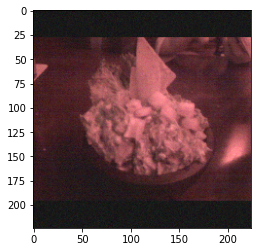

In [ ]:
t = train.dataset[1]

plt.imshow(t[0].transpose(1,2,0))
print(t[1])

In the pytorch approach I use onecycle learning rate schedule instead of some type of decay schedule, since it was shown to be better at short training.

In [ ]:
def get_custom_backbone():
    def conv_block(in_,out_,kernel=(3,3),strides=(1,1), padding='valid',activation='Mish'):
        layer = torch.nn.Sequential(
            torch.nn.Conv2d(in_,out_,kernel_size=kernel,stride=strides,padding=padding),
            torch.nn.LazyBatchNorm2d(),
            getattr(torch.nn,activation)(),
        )
        return layer
    
    model = torch.nn.Sequential(
        conv_block(3,32,strides=(2,2)),
        conv_block(32,64,strides=(1,1)),
        conv_block(64,128,kernel=(5,5),strides=(2,2)),
        conv_block(128,256,strides=(2,2)),
        conv_block(256,256,strides=(2,2)),
    )
    
    return model

def get_backbone(name=None,freeze=False):
    if name=='efficientnet':
        backbone = EfficientNet.from_pretrained('efficientnet-b0')
        to_remove = [n for n,_ in backbone.named_children()][-1:]
        for n in to_remove:
            setattr(backbone,n, torch.nn.Identity())
    elif name=='resnet':
        backbone = resnet50(pretrained=True)
        backbone.fc = torch.nn.Identity()
    else:
        backbone = get_custom_backbone()
    #print(list(backbone.modules())[0])
    for l in backbone.modules():
        l.requires_grad = not freeze
    return backbone

def get_model(backbone=None,freeze=False, lr=0.0005):
    model = torch.nn.Sequential(
        get_backbone(backbone,freeze),
        torch.nn.Flatten(),
        torch.nn.LazyLinear(128),
        torch.nn.LazyBatchNorm1d(),
        torch.nn.Mish(),
        torch.nn.LazyLinear(1),
        torch.nn.Sigmoid(),
        )
    
    optimizer = torch.optim.Adam(model.parameters(),lr=lr)
    loss = torch.nn.BCELoss()
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,max_lr=lr,epochs=20,steps_per_epoch=len(train))
    metrics_ = [metrics.BinaryAccuracy(),metrics.AUC(name='auc')]
    
    return {'model':model,'loss':loss,'optimizer':optimizer,'sch':scheduler,'metrics':metrics_}


I use a pytorch-lightning lib to handle training and valindation loops.
I have encountered a tiny inconvenience (perhaps a bug) while logging end-of-epoch validation metrics. In stead of logging an average of validation metrics over epoch I am only able to plot metrics of the last validation batch.

In [ ]:
def train_model(model_dict):
    class PLModel(pl.LightningModule):
        def __init__(self):
            super().__init__()
            self.model = model_dict['model']
            self.metrics = model_dict['metrics']
            self.loss = model_dict['loss']

        def forward(self,x):
            return self.model(x)
        
        def evaluate(self,data):
            preds = []
            trues = []
            self.model.eval()
            for x,y in data:
                preds.extend(self.model(x).cpu().detach().numpy().flatten())
                trues.extend(y.cpu().numpy())
            for m in self.metrics:
                print(m.name,': ',m(trues,preds))

        def training_step(self,batch,batch_idx):
            x,y = batch
            pred = self(x).flatten()
            loss = self.loss(pred,y)
            results = {'loss':loss}
            for m in self.metrics:
                results[m.name] = m(y.cpu(),pred.cpu().detach().numpy()).numpy()
            for i,k in results.items():
                self.log(i,k,on_epoch=True)
            return results

        def validation_step(self,batch,batch_idx):
            x,y = batch
            pred = self(x).flatten()
            loss = self.loss(pred,y)
            results = {'val_loss':loss}
            for m in self.metrics:
                results['val_'+m.name] = m(y.cpu(),pred.cpu().detach().numpy()).numpy()
            for i,k in results.items():
                self.log(i,k,on_epoch=True)
            return results

        def test_step(self,batch,batch_idx):
            x,y = batch
            pred = self(x).flatten()
            loss = self.loss(pred,y)
            results = {'test_loss':loss}
            for m in self.metrics:
                results['test_'+m.name] = m(y.cpu(),pred.cpu().detach().numpy()).numpy()
            for i,k in results.items():
                self.log(i,k,on_epoch=True)
            return results
        
        def configure_optimizers(self):
            return ([model_dict['optimizer']],{'scheduler': model_dict['sch'], 'interval': 'epoch'})

    class MyLogger(pl.callbacks.Callback):
        def __init__(self):
            self.logger = {}

        def on_validation_epoch_end(self, trainer,module):
            m = trainer.logged_metrics
            #print('val',m)
            for i,k in m.items():
                if i.startswith('val'):
                    self.logger[i] = self.logger.get(i,[])+[k]

        def on_train_epoch_end(self, trainer,module):
            m = trainer.logged_metrics
            #print('tr',m)
            for i,k in m.items():
                if i.endswith('epoch'):
                    self.logger[i] = self.logger.get(i,[])+[k]


    pl_model = PLModel()
    early_stop = pl.callbacks.early_stopping.EarlyStopping(monitor='val_binary_accuracy',mode='max',patience=3)
    log = MyLogger()
    try:
        trainer = pl.Trainer(gpus=1,max_epochs=20,callbacks=[early_stop,log])
    except :
        trainer = pl.Trainer(max_epochs=20,callbacks=[early_stop,log])

    trainer.fit(pl_model,train,valid)
    history = log.logger
    f,axes = plt.subplots(1,2,figsize=(10,7))
    axes[0].plot(history['loss_epoch'],label='loss')
    axes[0].plot(history['val_loss'],label='val_loss')
    axes[0].legend()
    axes[1].plot(history['binary_accuracy_epoch'],label='accuracy')
    axes[1].plot(history['val_binary_accuracy'],label='val_accuracy')
    axes[1].legend()

    plt.title('Learning curves')
    plt.show()
    
    print('TEST RESULTS: - - - - -')
    print(pl_model.evaluate(test))
    

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 1.1 M 
1 | loss  | BCELoss    | 0     
-------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.438     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:377: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for val/test/predict dataloaders.
  f"Your {mode}_dataloader has `shuffle=True`, it is best practice to turn"


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

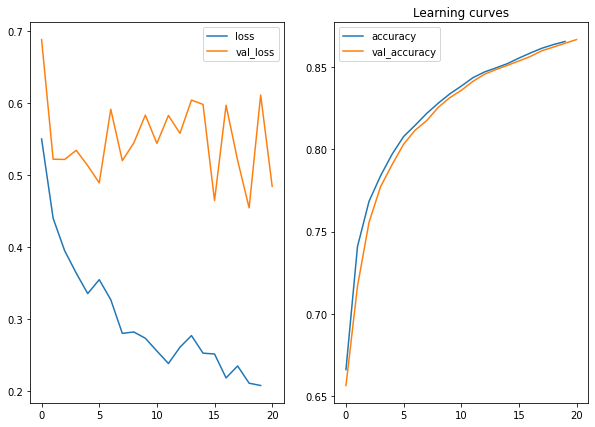

TEST RESULTS: - - - - -
binary_accuracy :  tf.Tensor(0.86623484, shape=(), dtype=float32)
auc :  tf.Tensor(0.9398199, shape=(), dtype=float32)
None


In [ ]:
m = get_model(freeze=False, lr=0.001)
train_model(m);

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 5.3 M 
1 | loss  | BCELoss    | 0     
-------------------------------------
5.3 M     Trainable params
0         Non-trainable params
5.3 M     Total params
21.154    Total estimated model params size (MB)


Loaded pretrained weights for efficientnet-b0


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:377: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for val/test/predict dataloaders.
  f"Your {mode}_dataloader has `shuffle=True`, it is best practice to turn"


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

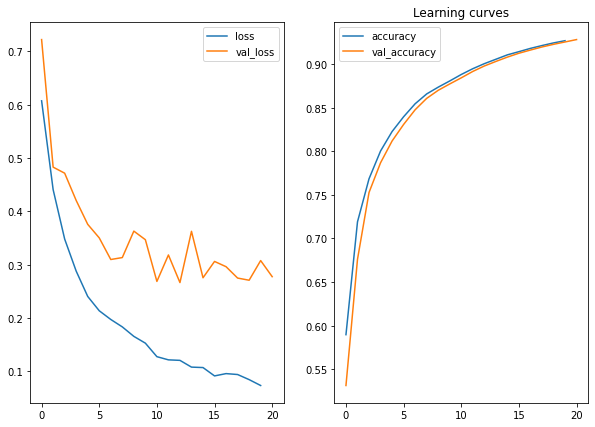

TEST RESULTS: - - - - -
binary_accuracy :  tf.Tensor(0.92830145, shape=(), dtype=float32)
auc :  tf.Tensor(0.98296607, shape=(), dtype=float32)
None


In [ ]:
m_eff_frozen = get_model('efficientnet',freeze=True)
train_model(m_eff_frozen)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loaded pretrained weights for efficientnet-b0



  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 5.3 M 
1 | loss  | BCELoss    | 0     
-------------------------------------
5.3 M     Trainable params
0         Non-trainable params
5.3 M     Total params
21.154    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:377: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for val/test/predict dataloaders.
  f"Your {mode}_dataloader has `shuffle=True`, it is best practice to turn"


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

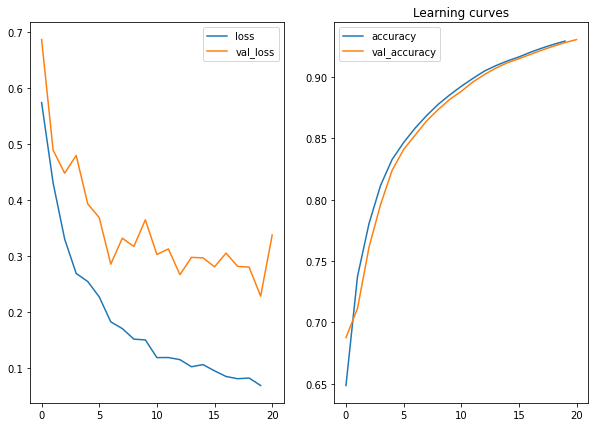

TEST RESULTS: - - - - -
binary_accuracy :  tf.Tensor(0.9306001, shape=(), dtype=float32)
auc :  tf.Tensor(0.9839844, shape=(), dtype=float32)
None


In [ ]:
m_eff = get_model('efficientnet',freeze=False)
train_model(m_eff)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 23.5 M
1 | loss  | BCELoss    | 0     
-------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.032    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:377: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for val/test/predict dataloaders.
  f"Your {mode}_dataloader has `shuffle=True`, it is best practice to turn"


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

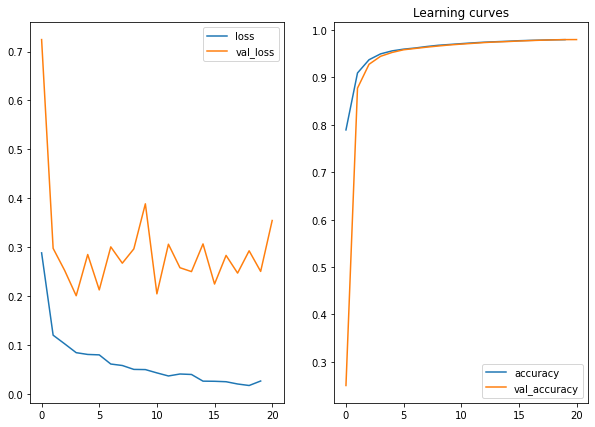

TEST RESULTS: - - - - -
binary_accuracy :  tf.Tensor(0.979869, shape=(), dtype=float32)
auc :  tf.Tensor(0.99759185, shape=(), dtype=float32)
None


In [ ]:
m_res_frozen = get_model('resnet',freeze=True)
train_model(m_res_frozen)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 23.5 M
1 | loss  | BCELoss    | 0     
-------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.032    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:377: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for val/test/predict dataloaders.
  f"Your {mode}_dataloader has `shuffle=True`, it is best practice to turn"


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

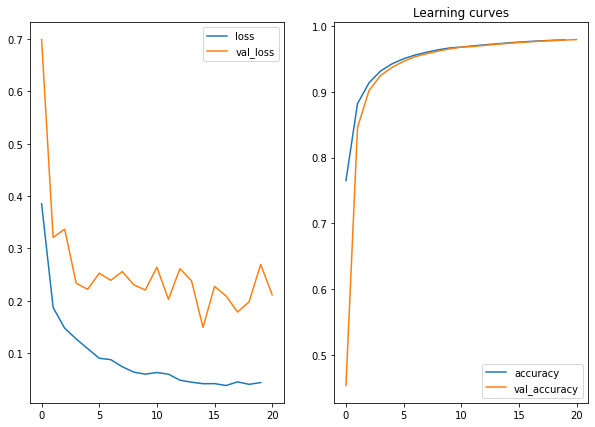

TEST RESULTS: - - - - -
binary_accuracy :  tf.Tensor(0.97942287, shape=(), dtype=float32)
auc :  tf.Tensor(0.99761355, shape=(), dtype=float32)
None


In [ ]:
m_res = get_model('resnet',freeze=False)
train_model(m_res)

As seen from literally all the experiments, OneCycle lr_sched outperformed CosineDecay. Onecycle made the learning curve more smooth and monotone.